# MNIST Workshop

This is the starting code for EVC Computer Science Club meeting 7. We're building a simple image classifier for the MNIST dataset

There documentation we will be frequently referencing the following
*   https://pytorch.org/tutorials/beginner/basics/intro.html
*   https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html



If you haven't already, please follow/join our socials
*   Discord: https://discord.gg/kT4hM7mu3G
*   Instagram: @evccsc

# Data Loading

This code is processing the data.

It is not super important to look at, just know that

1. The data we are processing is 28 x 28 pixel images of single-digit numbers. These numbers are labeled 0-9

2. At the end of the data processing, we get "dataloaders." Dataloaders are iterators, and when you iterate them you get data in batches. This data is in the form of \[images, labels\]

In [ ]:
# Note: Batch size was set to 32, but common values are 32 and 64
Batch_Size = 32

# Q: What are batches?
# Models train in "batches" of data. In this case, we train the model on 32 images at once.
# We input these 32 images and make the model give predictions for all 32 of these images.
# Then, we for all 32 of these images, we calculate how wrong we are with "loss." We use this
# information to correct our model.

# Batch training is done for efficiency reasons

In [ ]:
# Loading Data

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


transform = transforms.Compose({
    transforms.ToTensor()
})

# Loading the data
traindata = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_set= torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Split into validation and training datasets
val_size = int(len(traindata)*0.2)
train_size = int(len(traindata)*0.8)

train_set, val_set = torch.utils.data.random_split(traindata, [train_size, val_size])

train_dataloader = DataLoader(train_set, batch_size = Batch_Size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size = Batch_Size, shuffle=False)
test_dataloader = DataLoader(test_set, batch_size = Batch_Size, shuffle=False)

Train Loader Images:


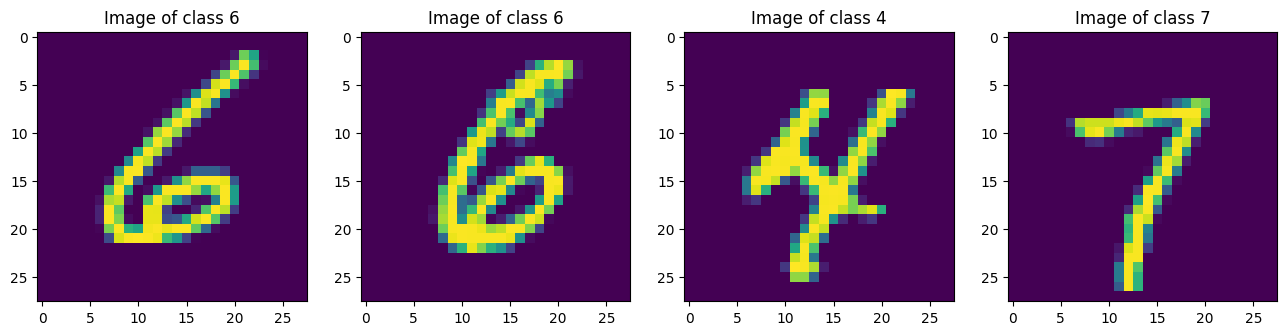

In [ ]:
# Visualizing data
# view a couple of sample images to make sure they are loaded

import matplotlib.pyplot as plt
import numpy as np

def display_img_examples(loader):
  images, labels = next(iter(loader))
  images = images.numpy()
  plt.figure(figsize=(16, 4))
  for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(np.transpose(images[i], (1, 2, 0))) # actually don't know why I transposed "(1, 2, 0)" lol, probably can ask GPT to explain it
    plt.axis('on')
    plt.title(f"Image of class {labels[i].item()}")
  plt.show()

print("Train Loader Images:")
display_img_examples(train_dataloader)

# Defining the Model

We are trying to build a feedforward neural network.

*   Feel free to change up the model, including modifying the number of neurons or adding layers!
*   Remember that the model should have 28 x 28 inputs, and there are 10 output classes.

Reference the documentation to do this part
https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

In [ ]:
import torch
from torch import nn

class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # defining the flatten function

        # <-------- layers defined here - Please play around with -------->

        # input layer = 784 neurons - No coincidence, since a flattened 28x28 image has 784 neurons
        # hidden layer = 512 neurons - Feel free to change, or even add more layers
        # output layer = 10 neurons - There are 10 classes that the model is trying to predict

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 200),
            nn.ReLU(),
            nn.Linear(200, 10),
        )

    def forward(self, x):
        x_flattened = self.flatten(x) # flatten image input

        # Process input through model
        logits = self.linear_relu_stack(x_flattened)
        return logits


In [ ]:
# Function that can be used to evaluate model. Outputs (average loss, percent correct)
def eval_model(model, data_loader, loss_fn):
  total_correct = 0
  total_loss = 0

  model.eval()

  with torch.no_grad(): # make sure the model isn't calculating gradients using no_grad() while evaluating
    for inputs, targets in data_loader:
      predictions = model(inputs)

      loss = loss_fn(predictions, targets)
      total_loss += loss.item()

      predicted_classes = torch.argmax(predictions, dim=1)
      correct_predictions = (predicted_classes == targets)
      correct_predictions = correct_predictions.float()
      num_correct = correct_predictions.sum()
      total_correct += num_correct

  return total_loss/len(data_loader), round(100*float(total_correct / (len(data_loader)*Batch_Size)), 3)

In [ ]:
# Visualization function:
# Takes four images from a dataloader and gets predictions from the
# model. Then, it displays images labeled with model predictions

def prediction_visual(model, dataloader):
  images, labels = next(iter(dataloader))

  # Step 1: Grab the first 4 images (and optionally their labels)
  images = images[:4]  # Shape (4, 28, 28) assuming 28x28 images

  # Step 2: Pass the images through the model
  model.eval()  # Set model to evaluation mode
  with torch.no_grad():  # No gradient calculation needed for evaluation
      predictions = model(images)  # Get model outputs for the first 4 images

  # Step 3: Process the predictions
  predicted_classes = torch.argmax(predictions, dim=1)  # Get the predicted class for each image
  predicted_classes = predicted_classes.numpy()

  images = images.numpy()
  plt.figure(figsize=(16, 4))
  for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(np.transpose(images[i], (1, 2, 0))) # actually don't know why I transposed "(1, 2, 0)" lol, probably can ask GPT to explain it
    plt.axis('on')
    plt.title(f"Predicted image class: {predicted_classes[i]}")
  plt.show()

# Training the model

Rough idea:

1. We use a "loss function" to calculate how bad our model is. One loss functions we've learned before is the "mean-square error," but in this case we're actually using a different loss function called "cross entropy." They work similarly though, telling us how bad our model is.

2. We define a optimizer that will adjust the weights and biases of our previously defined model

3. Load in a batch of images and get our model predictions for the classes of these images. Then, calculate how wrong we are using the loss function, and use the optimizer to update our model parameters.

4. Repeat this until the the model has been trained on every image in the training dataset

5. (Optional) Test accuracy of the model at this stage

6. Repeat 3-5 until model is good. Number of times we repeat steps 3-5 is called "Epochs"


Please use this documentation as reference:
https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

You may skip to "Full implementation" part but feel free to read through it as well


In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):

  # Set the model to training mode
  model.train()

  for inputs, targets in dataloader:

    # Compute prediction and loss
    pred = model(inputs)
    loss = loss_fn(pred, targets)

    # Backpropagation - this is how you adjust the model weights in pytorch
    loss.backward() # set gradients
    optimizer.step() # adjust model gradients
    optimizer.zero_grad() # clear the gradients (otherwise it will linger and interfere with future optimization)


In [ ]:
#initialize model
model = NeuralNet()

# Loss function is cross-entropy loss - feel free to search up!
loss_fn = nn.CrossEntropyLoss()

#optimizer is called Stocastic Gradient Descent (SGD) - feel free to search up!
learning_rate = 0.01 # learning rate = how fast your model learns. Learning rate usually is between 1e-1 and 1e-5
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Before training, let's see how bad our model is:

In [ ]:
prediction_visual(model, test_dataloader)

test_initial_loss, test_initial_accuracy = eval_model(model, val_dataloader, loss_fn)
print(f"Initial Metrics: \n Loss: {test_initial_loss} \n Accuracy: {test_initial_accuracy}%")


NameError: name 'prediction_visual' is not defined

Now let's train our model to make it better!

In [ ]:
Epochs = 10 # if you want to longer training, increase number

# initial model evaluation

loss_history = []
accuracy_history = []

initial_loss, initial_accuracy = eval_model(model, val_dataloader, loss_fn)

print(f"Epoch 0: \n Loss: {initial_loss} \n Accuracy: {initial_accuracy}%")

loss_history.append(initial_loss)
accuracy_history.append(initial_accuracy)

for i in range(Epochs):
  train_loop(train_dataloader, model, loss_fn, optimizer)

  cur_loss, cur_accuracy = eval_model(model, val_dataloader, loss_fn)

  print(f"Epoch {i+1}: \n Loss: {cur_loss} \n Accuracy: {cur_accuracy}%")
  loss_history.append(cur_loss)
  accuracy_history.append(cur_accuracy)

test_loss, test_accuracy = eval_model(model, test_dataloader, loss_fn)
print(f"Final metrics: \n Loss: {test_loss} \n Accuracy: {test_accuracy}%")


Epoch 0: 
 Loss: 2.3023352088928224 
 Accuracy: 8.633%
Epoch 1: 
 Loss: 2.2883534978230795 
 Accuracy: 21.625%
Epoch 2: 
 Loss: 2.268411018371582 
 Accuracy: 37.5%
Epoch 3: 
 Loss: 2.2320130526224773 
 Accuracy: 52.042%
Epoch 4: 
 Loss: 2.1516590302785237 
 Accuracy: 54.175%
Epoch 5: 
 Loss: 1.957162182490031 
 Accuracy: 56.6%
Epoch 6: 
 Loss: 1.562496890703837 
 Accuracy: 66.842%
Epoch 7: 
 Loss: 1.106938956260681 
 Accuracy: 73.892%
Epoch 8: 
 Loss: 0.8370940912564595 
 Accuracy: 77.467%
Epoch 9: 
 Loss: 0.7005277010599772 
 Accuracy: 80.2%
Epoch 10: 
 Loss: 0.6154368600845337 
 Accuracy: 82.617%
Final metrics: 
 Loss: 0.5945553166416887 
 Accuracy: 83.247%


# Visualizing the model's progress

Here are some cool visuals :D

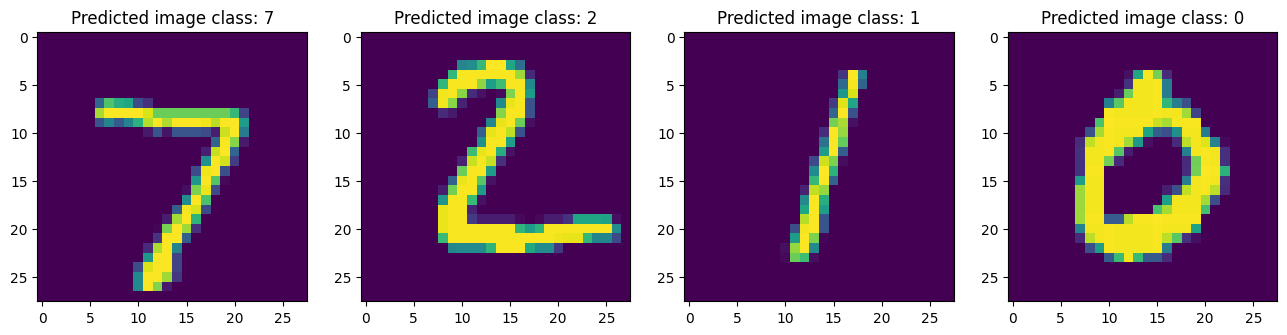

In [ ]:
prediction_visual(model, test_dataloader)

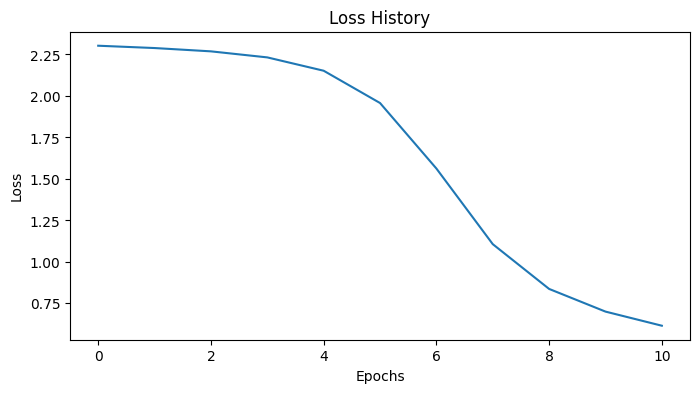

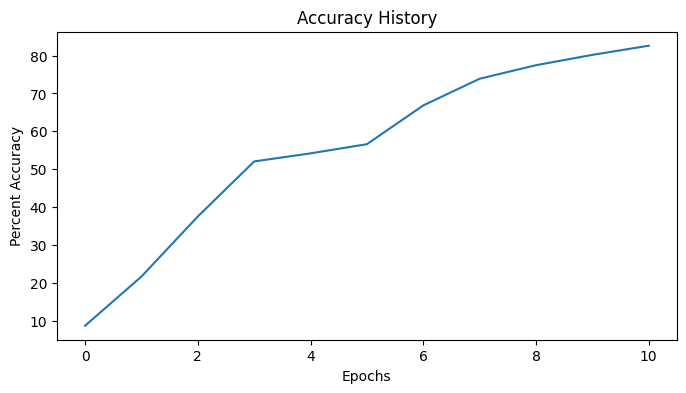

In [ ]:
# Graphs of loss and accuracy over training

plt.figure(figsize=(8, 4))
plt.plot(loss_history, label="Validation Loss History")
plt.title("Loss History")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(accuracy_history, label="Validation Accuracy History")
plt.title("Accuracy History")
plt.xlabel("Epochs")
plt.ylabel("Percent Accuracy")
plt.show()